# Análise dos dados de voos atrasados

## Importando Bibliotecas

In [2]:
# Ignorar avisos 
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

## Carragando o Banco de Dados

In [33]:
df = pd.read_csv('DelayedFlights.zip')

In [34]:
df['Year'].unique() # só ha valores de 2008

array([2008], dtype=int64)

In [35]:
# Excluindo a primeira coluna
df = df.drop(df.columns[:1], axis=1)

In [36]:
# Excluindo colunas que não serão utilizadas na análise
df.drop(['Year','TaxiIn', 'TaxiOut', 'TailNum', 'FlightNum', 'UniqueCarrier',
        'DepTime', 'CRSDepTime','ArrTime','CRSArrTime'], # horários
                       axis=1, inplace=True)

In [37]:
print('Verificando se há valores de tempo negativos')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<0]['AirTime']))

Verificando se há valores de tempo negativos
ActualElapsedTime 0
CRSElapsedTime 6
AirTime 0


In [38]:
print('Verificando se há valores de tempo zerados ou negativos')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<=0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<=0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<=0]['AirTime']))

Verificando se há valores de tempo zerados ou negativos
ActualElapsedTime 0
CRSElapsedTime 6
AirTime 7


- 'CRSElapsedTime' registra o tempo de voo programado em minutos, valores negativos são valores incosistentes, logo, precisam ser retirados.

In [39]:
df = df[df['CRSElapsedTime']>=0]

Valores Zerados ou são de voos cancelados, Desviados ou são registros errados

In [40]:
# Filtrando voos não cancelados
df = df[df['Cancelled']==0]
# como já foi retirado os cancelados, não precisa manter a coluna de cancelados e seus motivos
df.drop(['Cancelled','CancellationCode'],axis=1, inplace=True)
# filtrando os voos não desviados
df = df[df['Diverted']==0]
df.drop(['Diverted'],axis=1, inplace=True)
# os dados de voos cancelados e desviados serão analisados a parte


In [41]:
print('Verificando se há valores de tempo zerados ou negativos')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<=0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<=0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<=0]['AirTime']))

Verificando se há valores de tempo zerados ou negativos
ActualElapsedTime 0
CRSElapsedTime 0
AirTime 7


como o AirTime ainda apareceu valores inconsistentes, foram retirados do df

In [42]:
df= df[df['AirTime']>0]

In [43]:
# verificando se foram retirados todos os dados zerados nas colunas especificadas
print('Verificando se há valores de tempo zerados')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<=0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<=0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<=0]['AirTime']))

Verificando se há valores de tempo zerados
ActualElapsedTime 0
CRSElapsedTime 0
AirTime 0


Verificar a quantidade de linhas com valores nulos

In [44]:
df.isnull().sum().sort_values(ascending=False)

CarrierDelay         680881
WeatherDelay         680881
NASDelay             680881
SecurityDelay        680881
LateAircraftDelay    680881
Month                     0
DayofMonth                0
DayOfWeek                 0
ActualElapsedTime         0
CRSElapsedTime            0
AirTime                   0
ArrDelay                  0
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
dtype: int64

Voos que não sofreram atrasos são caracterizados por valores nulos nas colunas que demonstram qualquer tipo de atraso (LateAircraftDelay, SecurityDelay, NASDelay, WeatherDelay e CarrierDelay)

In [45]:
df = df[df.notnull().all(axis=1)]  # DataFrame sem linhas contendo valores nulos

In [46]:
print('verificado os nulos depois do tratamento')
df.isnull().sum().sort_values(ascending=False)

verificado os nulos depois do tratamento


Month                0
DayofMonth           0
DayOfWeek            0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [47]:
lista_var_continuas = ['ActualElapsedTime','CRSElapsedTime', 
                       'AirTime','ArrDelay','DepDelay','Distance',
                       'CarrierDelay','WeatherDelay','SecurityDelay',
                       'NASDelay','LateAircraftDelay']
lista_var_discretas = ['Month','DayofMonth','DayOfWeek']

In [48]:
df[lista_var_continuas].describe()

ActualElapsedTime  CRSElapsedTime    AirTime   ArrDelay   DepDelay  \
count         1247482.00      1247482.00 1247482.00 1247482.00 1247482.00   
mean              135.38          131.76     107.42      63.29      59.68   
std                72.30           69.53      68.17      60.75      59.87   
min                14.00            1.00       1.00      15.00       6.00   
25%                83.00           80.00      58.00      26.00      24.00   
50%               118.00          115.00      90.00      43.00      41.00   
75%               167.00          161.00     136.00      79.00      75.00   
max              1114.00          660.00    1091.00    2461.00    2467.00   

        Distance  CarrierDelay  WeatherDelay  SecurityDelay   NASDelay  \
count 1247482.00    1247482.00    1247482.00     1247482.00 1247482.00   
mean      741.59         19.18          3.70           0.09      15.02   
std       559.36         43.55         21.49           2.02      33.83   
min        11.00          0.00          0.00           0.00       0.00   
25%       334.00          0.00          0.00           0.00       0.00   
50%       595.00          2.00          0.00           0.00       2.00   
75%       972.00         21.00          0.00           0.00      15.00   
max      4962.00       2436.00       1352.00         392.00    1357.00   

       LateAircraftDelay  
count         1247482.00  
mean               25.30  
std                42.05  
min                 0.00  
25%                 0.00  
50%                 8.00  
75%                33.00  
max              1316.00

Podemos verificar que há uma grande diferença ente o valor máximo e o quartil 75% para as variáveis que quantificam o atraso

In [49]:
# Configurar opções de exibição para evitar notação científica
pd.set_option('display.float_format', '{:.2f}'.format)

# Mostrar estatísticas descritivas sem notação científica
print(df['ArrDelay'].describe(percentiles=[0.75, 0.80, 0.90, 0.95]))

count   1247482.00
mean         63.29
std          60.75
min          15.00
50%          43.00
75%          79.00
80%          91.00
90%         132.00
95%         176.00
max        2461.00
Name: ArrDelay, dtype: float64


serão retirados os registros com atraso maior que o quantil de 95% por se tratar de uma ocorrência rara

In [50]:
# Calcular o quantil de 95%
quantil = df['ArrDelay'].quantile(0.95)

# Aplicar o filtro
df  = df.loc[df['ArrDelay'] <= quantil]

Levando em consideração que o campo AirTime indica o tempo no ar em minutos, não faz sentido que um voo dure apenas uns minutos no ar. Por isso, será retirado os primeiro 5% dos dados de AirTime

In [51]:
# Calcular o quantil de 5%
quantil_5 = df['AirTime'].quantile(0.05)

# Aplicar o filtro
df  = df.loc[df['AirTime'] >= quantil_5]

# Calcular o quantil de 5%
quantil_5 = df['CRSElapsedTime'].quantile(0.05)

# Aplicar o filtro
df  = df.loc[df['CRSElapsedTime'] >= quantil_5]

In [52]:
df['ActualElapsedTime'].describe(percentiles=[0.75,0.85,0.9,0.93,0.95])

count   1073266.00
mean        142.65
std          70.27
min          40.00
50%         125.00
75%         172.00
85%         209.00
90%         240.00
93%         266.00
95%         290.00
max         790.00
Name: ActualElapsedTime, dtype: float64

In [53]:
# como voos extremamentes longos são incomuns, voos que duraram mais de 90% que o conjunto de dados serão retirados
# Calcular o quantil de 95%
quantil = df['ActualElapsedTime'].quantile(0.9)

# Aplicar o filtro
df  = df.loc[df['ActualElapsedTime'] <= quantil]

In [176]:
# no mesmo sentido, voos com distâncias extremamente longas são incomuns, então serão retirados para melhor análise dos dados

In [54]:
df['Distance'].describe(percentiles=[0.75,0.85,0.9,0.95])

count   966870.00
mean       663.97
std        353.73
min         67.00
50%        595.00
75%        892.00
85%       1040.00
90%       1147.00
95%       1379.00
max       2288.00
Name: Distance, dtype: float64

In [55]:
quantil = df['Distance'].quantile(0.95)

# Aplicar o filtro
df  = df.loc[df['Distance'] <= quantil]

In [56]:
df[lista_var_continuas].describe()

ActualElapsedTime  CRSElapsedTime   AirTime  ArrDelay  DepDelay  \
count          919143.00       919143.00 919143.00 919143.00 919143.00   
mean              120.20          117.52     93.02     53.58     50.90   
std                40.57           37.70     37.10     36.92     37.31   
min                40.00           62.00     34.00     15.00      6.00   
25%                86.00           85.00     62.00     25.00     23.00   
50%               115.00          111.00     87.00     41.00     40.00   
75%               149.00          145.00    120.00     72.00     69.00   
max               240.00          290.00    229.00    176.00    243.00   

       Distance  CarrierDelay  WeatherDelay  SecurityDelay  NASDelay  \
count 919143.00     919143.00     919143.00      919143.00 919143.00   
mean     617.66         15.59          2.81           0.09     12.76   
std      295.36         27.21         13.75           1.79     25.21   
min       67.00          0.00          0.00           0.00      0.00   
25%      369.00          0.00          0.00           0.00      0.00   
50%      581.00          2.00          0.00           0.00      1.00   
75%      849.00         20.00          0.00           0.00     14.00   
max     1379.00        176.00        176.00         170.00    176.00   

       LateAircraftDelay  
count          919143.00  
mean               22.33  
std                32.19  
min                 0.00  
25%                 0.00  
50%                 9.00  
75%                32.00  
max               176.00

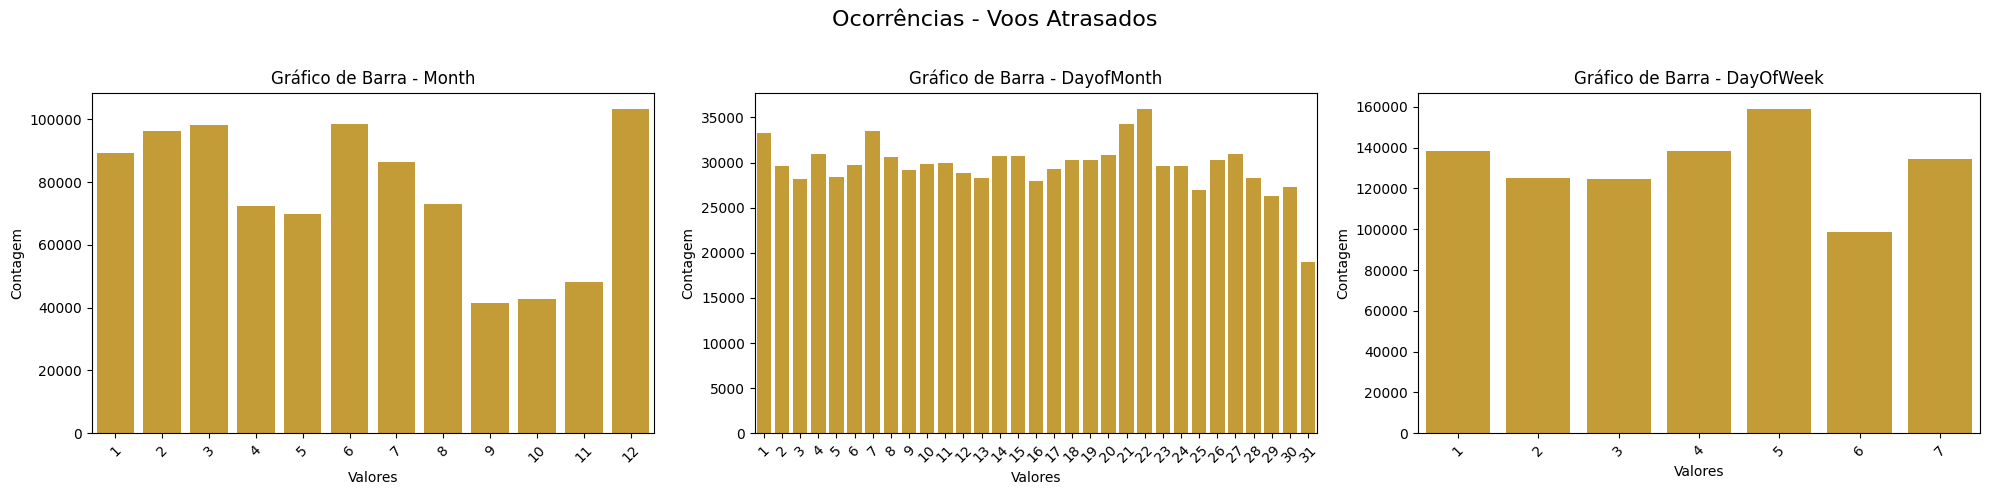

In [57]:
# Criar gráficos de barra para variáveis discretas
fig, axs =plt.subplots(1,3, figsize = (20,5))

for i, ax in zip(lista_var_discretas, axs.flatten()):
    sns.countplot(x=i, data=df[[i]], ax=ax, color='goldenrod')
    ax.set_title(f'Gráfico de Barra - {i}')
    ax.set_xlabel('Valores')
    ax.set_ylabel('Contagem')

    # Ajusta a rotação dos rótulos para melhor legibilidade
    ax.tick_params(axis='x', rotation=45)
# Adiciona um título geral acima dos subgráficos
fig.suptitle('Ocorrências - Voos Atrasados', fontsize=16)
# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o espaço para acomodar o título geral

# Exibe a figura
plt.show()

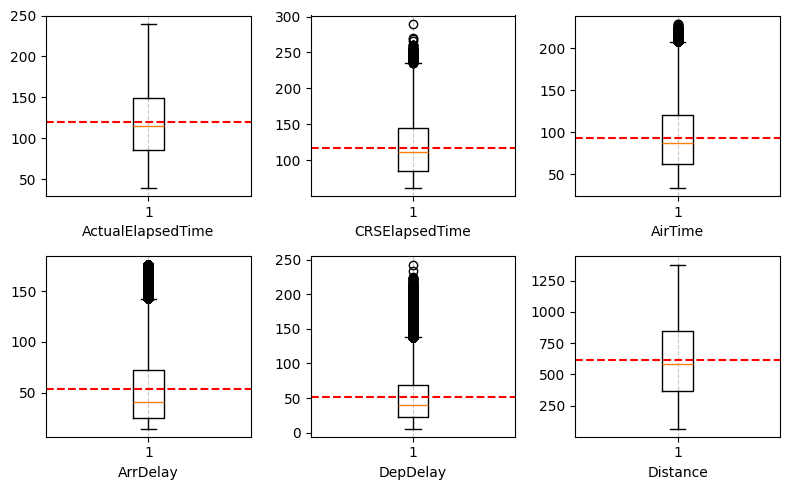

In [58]:
fig = plt.figure(figsize = (8,5))

for i, col in enumerate(df[['ActualElapsedTime','CRSElapsedTime', 
                       'AirTime','ArrDelay','DepDelay','Distance']]):
    plt.subplot(2,3,i+1)
    plt.boxplot(df[col])
    plt.xlabel(col)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axhline(y=df[col].mean(), linestyle='--', color="red")
    
plt.tight_layout()     
plt.show()

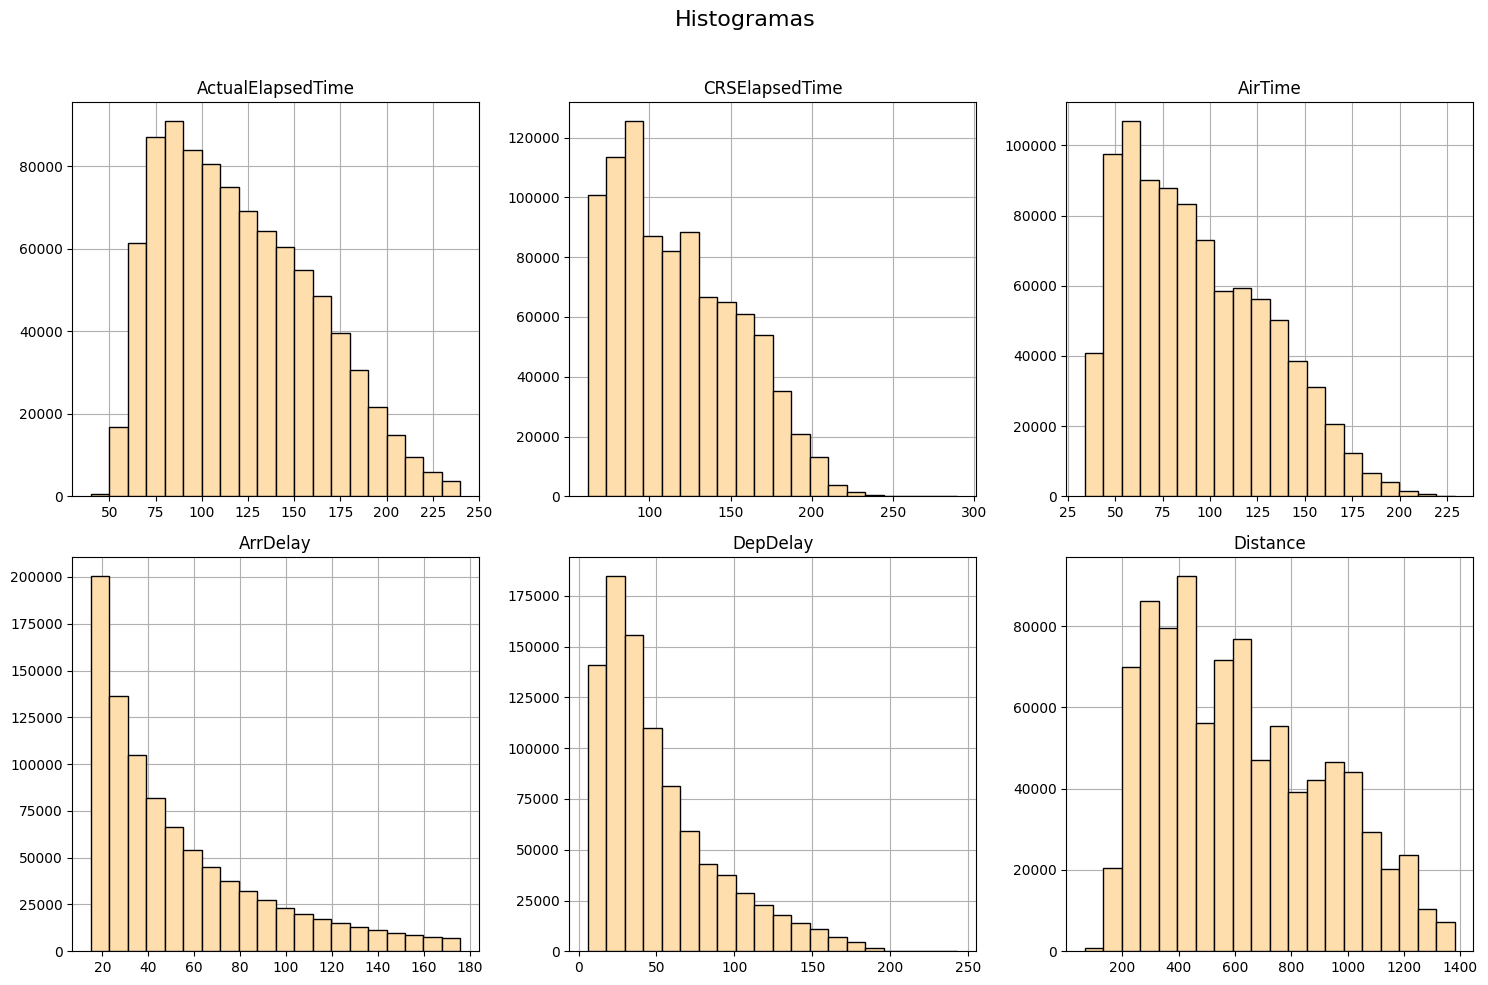

In [59]:
# Criação do grid de subgráficos 4x4
fig, axs = plt.subplots(2, 3, figsize=(15, 10))


for i, ax in zip(lista_var_continuas, axs.flatten()):
    df[i].hist(bins=20, edgecolor='black', color ='NavajoWhite',ax=ax, zorder=4)
    ax.set_title(f'{i}')
# Adiciona um título geral acima dos subgráficos
fig.suptitle('Histogramas', fontsize=16, zorder=1)  # Definindo zorder para o título geral

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o espaço para acomodar o título geral

plt.show()

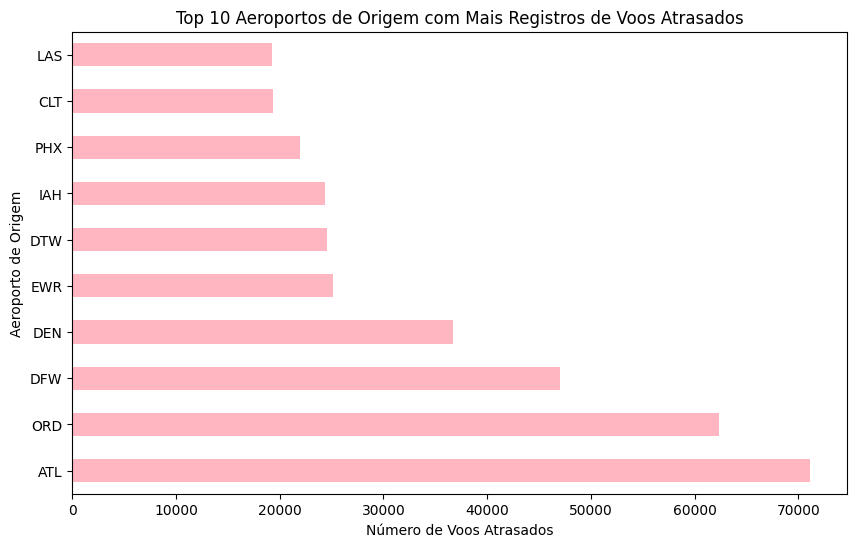

In [63]:
# Origem com mais registros de voos atrasados
top_origin_counts = df['Origin'].value_counts().nlargest(10)

# Criar gráfico de barras horizontais
plt.figure(figsize=(10, 6))
ax = top_origin_counts.plot(kind='barh', color='lightpink')

# Adicionar etiquetas e título
plt.xlabel('Número de Voos Atrasados')
plt.ylabel('Aeroporto de Origem')
plt.title('Top 10 Aeroportos de Origem com Mais Registros de Voos Atrasados')

plt.show()

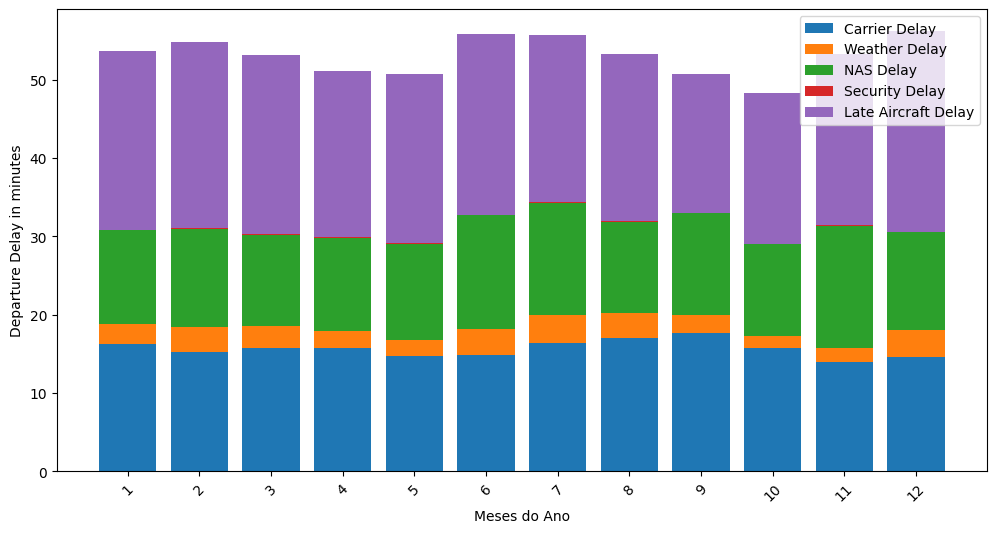

In [64]:
df['total_delay'] = (df['CarrierDelay'] + df['WeatherDelay']
             + df['NASDelay'] + df['SecurityDelay'] + df['LateAircraftDelay'])

df_delayed = df[~np.isnan(df['total_delay'])]
df['total_delay'].fillna(0, inplace=True)
df_delayed.head()

carrier_group = df_delayed['CarrierDelay'].groupby(df_delayed['Month']).mean()
weather_group = df_delayed['WeatherDelay'].groupby(df_delayed['Month']).mean()
nas_group = df_delayed['NASDelay'].groupby(df_delayed['Month']).mean()
security_group = df_delayed['SecurityDelay'].groupby(df_delayed['Month']).mean()
late_group = df_delayed['LateAircraftDelay'].groupby(df_delayed['Month']).mean()

w_bottom = carrier_group.values
n_bottom = w_bottom + weather_group.values
s_bottom = n_bottom + nas_group.values
l_bottom = s_bottom + security_group.values

x = carrier_group.index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),carrier_group.values, align='center', label='Carrier Delay')
ax.bar(np.arange(len(x)),weather_group.values, align='center', bottom=w_bottom, label='Weather Delay')
ax.bar(np.arange(len(x)),nas_group.values, align='center', bottom=n_bottom, label='NAS Delay')
ax.bar(np.arange(len(x)),security_group.values, align='center', bottom=s_bottom, label='Security Delay')
ax.bar(np.arange(len(x)),late_group.values, align='center', bottom=l_bottom, label='Late Aircraft Delay')

ax.set_xlabel('Meses do Ano')
ax.set_ylabel('Departure Delay in minutes')

plt.legend()
plt.show()

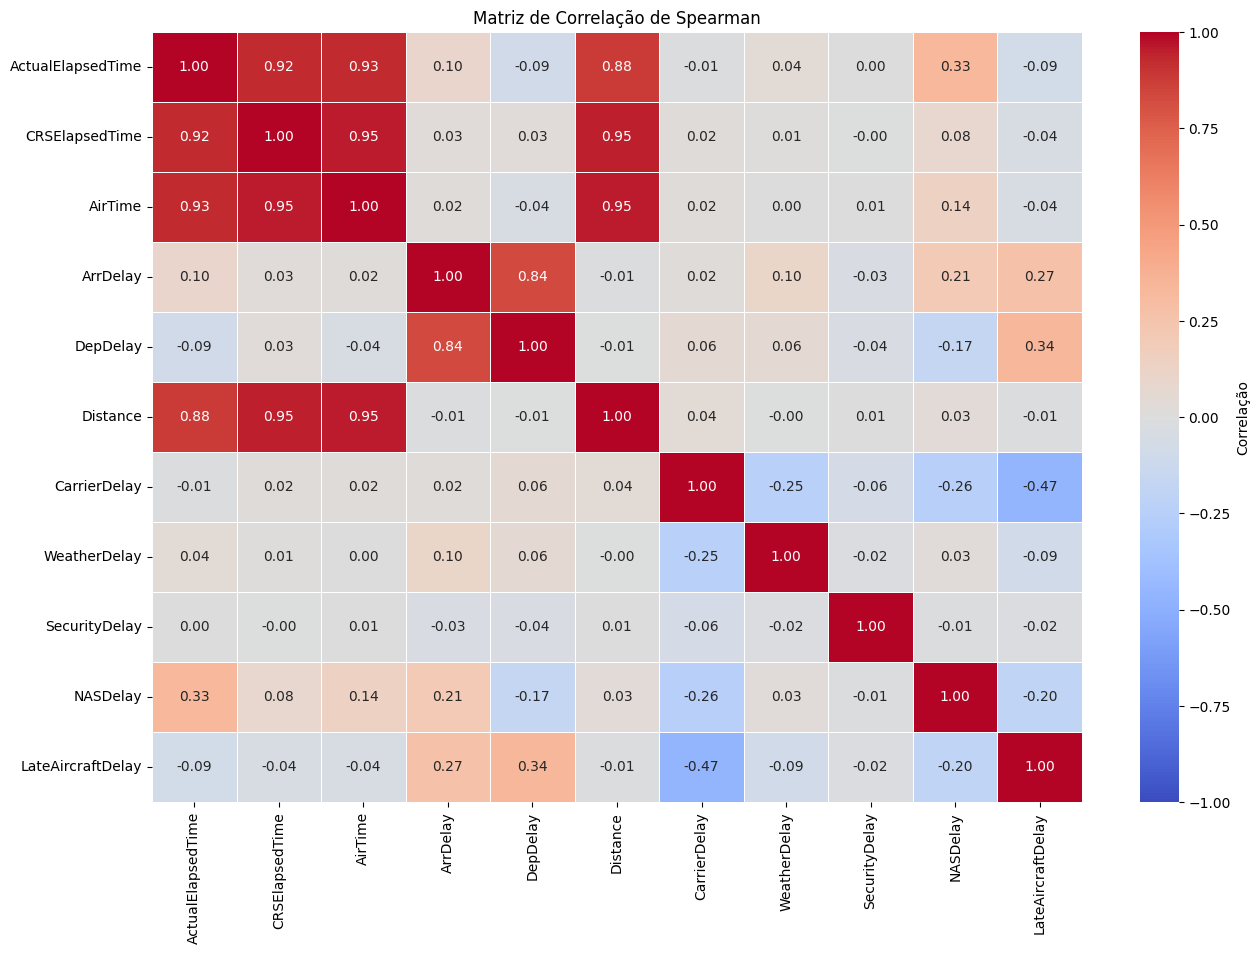

In [66]:
# Ajustando o tamanho do gráfico
plt.figure(figsize=(15, 10))

# Criando a matriz de correlação de Spearman
corr_matrix = df[lista_var_continuas].corr(method="spearman")

# Customizando o heatmap com Seaborn
sns.heatmap(corr_matrix, annot=True, 
            cmap="coolwarm", # cores de azul até vermelho
            vmin=-1, vmax=1,  # Valores máximos e mínimos da barra de cor
            fmt=".2f", linewidths=.5, 
            cbar_kws={"label": "Correlação"})

# Adicionando título
plt.title("Matriz de Correlação de Spearman")

# Exibindo o gráfico
plt.show()

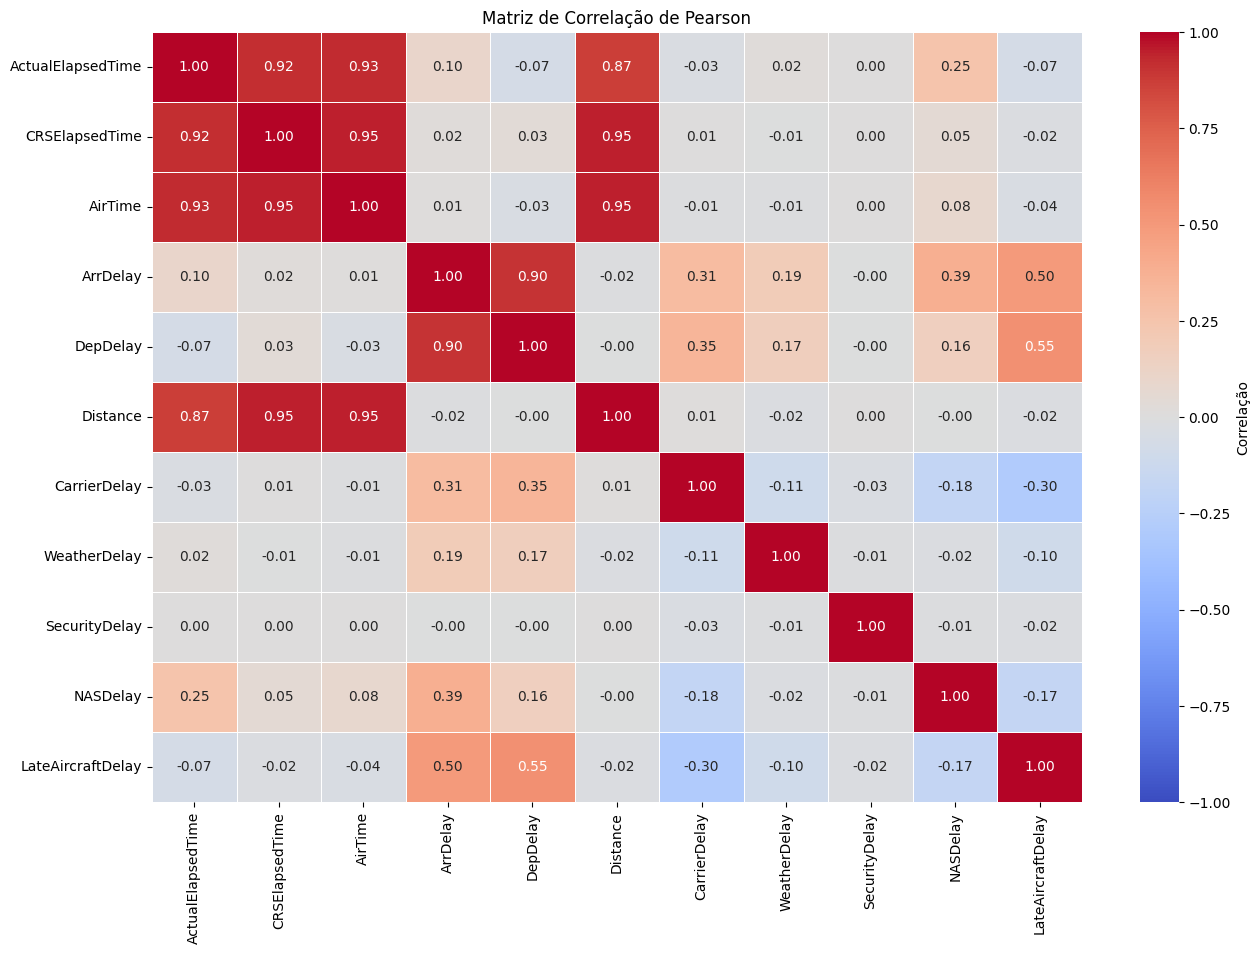

In [67]:
# Ajustando o tamanho do gráfico
plt.figure(figsize=(15, 10))

# Criando a matriz de correlação de Spearman
corr_matrix = df[lista_var_continuas].corr(method="pearson")

# Customizando o heatmap com Seaborn
sns.heatmap(corr_matrix, annot=True, 
            cmap="coolwarm", # cores de azul até vermelho
            vmin=-1, vmax=1,  # Valores máximos e mínimos da barra de cor
            fmt=".2f", linewidths=.5, 
            cbar_kws={"label": "Correlação"})

# Adicionando título
plt.title("Matriz de Correlação de Pearson")

# Exibindo o gráfico
plt.show()